In [18]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor as pt
import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import pytensor.sparse as sparsetensor
import arviz as az

import scienceplots
# plot params
contour_levels = 20
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [2]:
import sympy as sp

# Define the symbols and functions
x = sp.symbols('x')  # Spatial variable
u, u_0, phi, u_hat, v, v_0, v_hat, w, w_0, w_hat  = sp.symbols(r'u u_0 \varphi \hat{u} v v_0 \hat{v} w w_0 \hat{w}', cls=sp.Function)  # Functions
Delta_t, alpha, beta, c, nu, epsilon = sp.symbols(r'Delta_t \alpha \beta c \nu epsilon')  # Constants

# Define the derivatives
u_prime = sp.diff(u(x), x)
u_0prime = sp.diff(u_0(x),x)
v_prime = sp.diff(v(x), x)
v_0prime = sp.diff(v_0(x),x)
w_prime = sp.diff(w(x), x)
w_0prime = sp.diff(w_0(x),x)
phi_prime = sp.diff(phi(x), x)

# Define the functional F
#F = (u(x) + Delta_t * u(x) * u_prime - u_0(x)) * phi(x) + Delta_t * nu * u_prime * phi_prime
#F = (u(x)*(1+(Delta_t/2)*u_prime))*phi(x) + (Delta_t * nu / 2)*(u_prime*phi_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*phi(x) + (Delta_t*nu/2)*(u_0prime*phi_prime)

# F1 = (u(x)*phi(x) 
#       + (Delta_t * alpha / 2)*(u(x)*u_prime*phi(x)) 
#       + (Delta_t*beta/2)*(w_prime*phi(x)) 
#       + (Delta_t*c/2)*(u_prime*phi(x))
#       + (Delta_t*nu/2)*(u(x)*phi(x)) 
#       - (u_0(x)*phi(x)) 
#       + (Delta_t*alpha/2)*(u_0(x)*u_0prime*phi(x))
#       + (Delta_t*beta/2)*(w_0prime*phi(x))
#       + (Delta_t*c/2)*(u_0prime*phi(x))
#       + (Delta_t*nu/2)*(u_0(x)*phi(x)))
# F2 = phi(x)*(w(x) + w_0(x))/2 - phi(x)*(v_prime + v_0prime)/2
# F3 = phi(x)*(v(x) + v_0(x))/2 - phi(x)*(u_prime + u_0prime)/2

F1 = (u(x) - u_0(x))*phi(x) + (alpha*Delta_t/2)*(u(x)*v(x) + u_0(x)*v_0(x))*phi(x) + (Delta_t*beta/2)*(w_prime + w_0prime)*phi(x)
F2 = (v(x) - u_prime)*phi(x)
F3 = (v_prime - w(x))*phi(x)

# Define the perturbed functional F(u + epsilon * u_hat)
u_perturbed = u(x) + epsilon * u_hat(x)
u_perturbed_prime = sp.diff(u_perturbed, x)

v_perturbed = v(x) + epsilon * v_hat(x)
v_perturbed_prime = sp.diff(v_perturbed, x)

w_perturbed = w(x) + epsilon * w_hat(x)
w_perturbed_prime = sp.diff(w_perturbed, x)
#F_perturbed = (u_perturbed + Delta_t * u_perturbed * u_perturbed_prime - u_0(x)) * phi(x) + Delta_t * nu * u_perturbed_prime * phi_prime
#F_perturbed = (u_perturbed*(1+(Delta_t/2)*u_perturbed_prime))*phi(x) + (Delta_t * nu / 2)*(u_perturbed_prime*phi_prime) - (u_0(x)*(1-(Delta_t/2)*u_0prime))*phi(x) + (Delta_t*nu/2)*(u_0prime*phi_prime)

# F1_u_perturbed = (u_perturbed*phi(x) 
#                   + (Delta_t * alpha / 2)*(u_perturbed*u_perturbed_prime*phi(x)) 
#                   + (Delta_t*beta/2)*(w_prime*phi(x)) + (Delta_t*c/2)*(u_perturbed_prime*phi(x)) 
#                   + (Delta_t*nu/2)*(u_perturbed*phi(x)) - (u_0(x)*phi(x)) + (Delta_t*alpha/2)*(u_0(x)*u_0prime*phi(x)) 
#                   + (Delta_t*beta/2)*(w_0prime*phi(x)) + (Delta_t*c/2)*(u_0prime*phi(x)) + (Delta_t*nu/2)*(u_0(x)*phi(x))
#                   )
# F1_w_perturbed = (u(x)*phi(x) 
#                   + (Delta_t * alpha / 2)*(u(x)*u_prime*phi(x)) 
#                   + (Delta_t*beta/2)*(w_perturbed_prime*phi(x)) 
#                   + (Delta_t*c/2)*(u_prime*phi(x))+(Delta_t*nu/2)*(u(x)*phi(x)) 
#                   - (u_0(x)*phi(x)) + (Delta_t*alpha/2)*(u_0(x)*u_0prime*phi(x)) 
#                   + (Delta_t*beta/2)*(w_0prime*phi(x)) + (Delta_t*c/2)*(u_0prime*phi(x)) 
#                   + (Delta_t*nu/2)*(u_0(x)*phi(x)))
# F2_v_perturbed = phi(x)*(w(x) + w_0(x))/2 - phi(x)*(v_perturbed_prime + v_0prime)/2
# F2_w_perturbed = phi(x)*(w_perturbed + w_0(x))/2 - phi(x)*(v_prime + v_0prime)/2

# F3_u_perturbed = phi(x)*(v(x) + v_0(x))/2 - phi(x)*(u_perturbed_prime + u_0prime)/2
# F3_v_perturbed = phi(x)*(v_perturbed + v_0(x))/2 - phi(x)*(u_prime + u_0prime)/2

F1_u_perturbed = (u_perturbed - u_0(x))*phi(x) + (alpha*Delta_t/2)*(u_perturbed*v(x) + u_0(x)*v_0(x))*phi(x) + (Delta_t*beta/2)*(w_prime + w_0prime)*phi(x)
F1_v_perturbed = (u(x) - u_0(x))*phi(x) + (alpha*Delta_t/2)*(u(x)*v_perturbed + u_0(x)*v_0(x))*phi(x) + (Delta_t*beta/2)*(w_prime + w_0prime)*phi(x)
F1_w_perturbed = (u(x) - u_0(x))*phi(x) + (alpha*Delta_t/2)*(u(x)*v(x) + u_0(x)*v_0(x))*phi(x) + (Delta_t*beta/2)*(w_perturbed_prime + w_0prime)*phi(x)

F2_u_perturbed = (v(x) - u_perturbed_prime)*phi(x)
F2_v_perturbed = (v_perturbed - u_prime)*phi(x)

F3_v_perturbed = (v_perturbed_prime - w(x))*phi(x)
F3_w_perturbed = (v_prime - w_perturbed)*phi(x)

# Compute the Gâteaux derivative (directional derivative)
jacobian_11 = sp.limit((F1_u_perturbed - F1) / epsilon, epsilon, 0)
jacobian_12 = sp.limit((F1_v_perturbed - F1) / epsilon, epsilon, 0)
jacobian_13 = sp.limit((F1_w_perturbed - F1) / epsilon, epsilon, 0)
jacobian_21 = sp.limit((F2_u_perturbed - F2) / epsilon, epsilon, 0)
jacobian_22 = sp.limit((F2_v_perturbed - F2) / epsilon, epsilon, 0)
jacobian_32 = sp.limit((F3_v_perturbed - F3) / epsilon, epsilon, 0)
jacobian_33 = sp.limit((F3_w_perturbed - F3) / epsilon, epsilon, 0)

# Display the result
# Gateaux_derivative_simplified = sp.simplify(Gateaux_derivative)
# Gateaux_derivative_simplified

sp.simplify(F1)


(Delta_t*\alpha*(u(x)*v(x) + u_0(x)*v_0(x)) + Delta_t*\beta*(Derivative(w(x), x) + Derivative(w_0(x), x)) + 2*u(x) - 2*u_0(x))*\varphi(x)/2

In [2]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 400 #400

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = 0.
x_axis_right_boundary = 20.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.025
t_end = 0.5 #50.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_alpha = 1.
true_beta = 0.01
true_c = 0.
true_nu = 0.

mesh = fem.MeshLine(x_s)
v_element = fem.ElementLineP0()
u_element = fem.ElementLineP1()
u_basis = fem.Basis(mesh, u_element)
v_basis = fem.Basis(mesh, v_element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)

def sech(x):
    return 1 / np.cosh(x)

u_0true = -0.3*(sech(true_coordinates.flatten() - 15))**2
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.0001, len(u_0true))
u_guess[0] = u_guess[-1] 
u_guess[-2] = u_guess[1]

v_0true = np.gradient(u_0true)
v_strue = np.zeros((number_of_steps, n_x))
v_strue[0,:] = v_0true

v_guess = v_0true + np.random.normal(0, 0.0001, len(v_0true))
v_guess[0] = v_guess[-1]
v_guess[-2] = v_guess[1]

w_0true = np.gradient(v_0true)
w_strue = np.zeros((number_of_steps, n_x))
w_strue[0,:] = w_0true

w_guess = w_0true + np.random.normal(0, 0.0001, len(w_0true))
w_guess[0] = w_guess[-1]
w_guess[-2] = w_guess[1]

In [3]:
@fem.BilinearForm
def mass(u,v,w):
    return u*v

mass_mat = mass.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mass_mat[-1,-1] = mass_mat[-1,0] = mass_mat[0,0]

@fem.BilinearForm
def mixed(u,v,w):
    return grad(u)[0]*v

mixed_mat = mixed.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mixed_mat[-1,-1] = mixed_mat[0,0]
mixed_mat[-1,0] = mixed_mat[0,1]

ones_mat = np.ones(np.shape(mass_mat))
zeros_mat = np.zeros(np.shape(mass_mat))

In [4]:
ones_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], ones_mat)
ones_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], ones_mat)
ones_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], ones_mat)
ones_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], ones_mat)
ones_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], ones_mat)
ones_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], ones_mat)

mass_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mass_mat)
mass_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], mass_mat)
mass_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], mass_mat)

big_mass_mat = mass_11 + 0.5*mass_22 + 0.5*mass_33

mixed_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], mixed_mat)
mixed_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], mixed_mat)

big_mixed_mat = dt*0.5*mixed_11 + dt*0.5*mixed_12 - 0.5*mixed_23 - 0.5*mixed_31

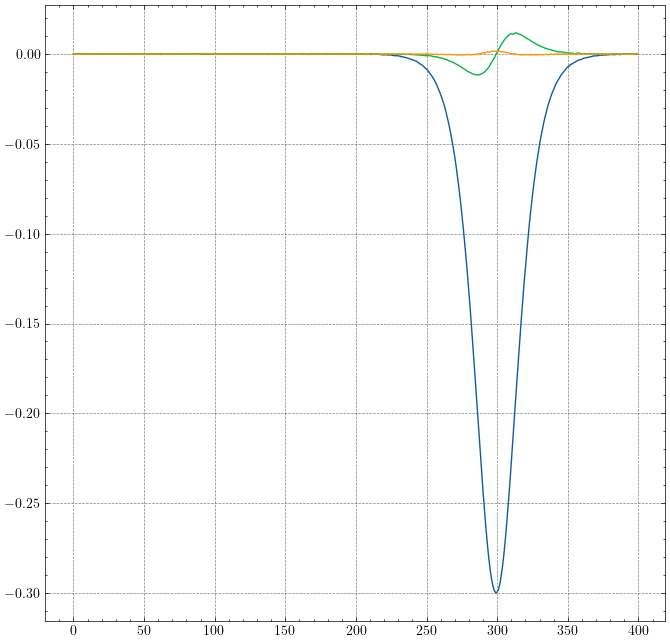

In [5]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(u_guess)
axes.plot(v_guess)
axes.plot(w_guess)

In [6]:
def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return np.concatenate((F1, F2, F3))

def fem_jacobian(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mass_mat=mass_mat):
    precompute = np.multiply(little_mass_mat, (u+u_prev)/2)
    big_precompute = np.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = np.multiply(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = np.multiply((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = np.multiply(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

# def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
#     F1 = (mass_mat @ (u - u_prev)
#           + (dt * nu) * mass_mat @ ((u + u_prev) / 2)
#           + (dt * alpha) * mixed_mat @ ((u + u_prev)**2 / 4) / 2
#           + (dt * beta) * mixed_mat @ ((w + w_prev) / 2)
#           + (dt * c) * mixed_mat @ ((u + u_prev) / 2)
#           )
#     F2 = mass_mat @ ((w + w_prev) / 2) - mixed_mat @ ((v + v_prev) / 2)
#     F3 = mass_mat @ ((v + v_prev) / 2) - mixed_mat @ ((u + u_prev) / 2)
#     return np.concatenate((F1, F2, F3))



# jac_base = (
#         np.kron(
#             [[dt * true_c, dt * true_beta, 0], [0, 0, -1], [-1, 0, 0]],
#             mixed_mat / 2
#             ) 
#             + np.kron(
#                 [[(1 + dt * true_nu / 2), 0, 0], [0, 1 / 2, 0], [0, 0, 1 / 2]],
#                 mass_mat
#             )
#         )

# def fem_jacobian(alpha, beta, c, nu, u, u_prev, mass_mat=mass_mat, mixed_mat=mixed_mat, jac_base = jac_base):
#     jacobian = (jac_base + np.kron(
#                     [[1, 0, 0], [0, 0, 0], [0, 0, 0]],
#                     dt * alpha * np.multiply(mixed_mat, ((u + u_prev) / 2)) / 2
#                     )
#         )
#     return jacobian



In [7]:
for i in tqdm(range(number_of_steps-1), desc='sim', position=0):
    du_norm = 1.
    u_prev, v_prev, w_prev = u_strue[i,:], v_strue[i,:], w_strue[i,:]
    #while du_norm > newton_tol:
    for j in tqdm(range(3), desc='newton', position=1, leave=False):
        f_curr = fem_lhs(true_alpha, true_beta, true_c, true_nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        j_curr = fem_jacobian(true_alpha, true_beta, true_c, true_nu, u_guess, u_prev)
        shift = np.linalg.solve(j_curr, -f_curr)
        u_guess += shift[0:n_x]
        w_guess += shift[n_x:2*n_x]
        v_guess += shift[2*n_x:]

        # du_norm = np.linalg.norm(shift)
        # print(du_norm)
        
    u_strue[i+1,:] = u_guess
    v_strue[i+1,:] = v_guess
    w_strue[i+1,:] = w_guess

sim: 100%|██████████| 19/19 [00:04<00:00,  4.13it/s]


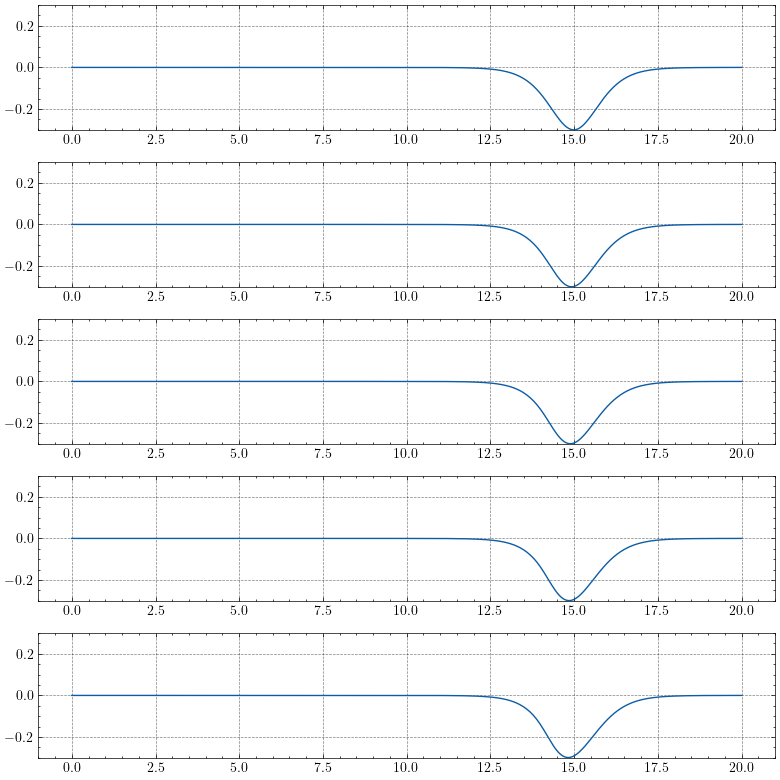

In [8]:
fig, axes = plt.subplots(5, 1, figsize=(8,8))
ymin = -0.3
ymax = 0.3
axes[0].plot(true_coordinates.flatten(),u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(true_coordinates.flatten(),u_strue[int(np.floor(2*number_of_steps/5))])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(true_coordinates.flatten(),u_strue[int(np.floor(3*number_of_steps/5))])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(true_coordinates.flatten(),u_strue[int(np.floor(4*number_of_steps/5))])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(true_coordinates.flatten(),u_strue[int(np.floor(5*number_of_steps/5 - 1))])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [9]:
# Observation Parameters
sigma_n_true = 0.001
spatial_points = 20
temporal_points = 1

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))


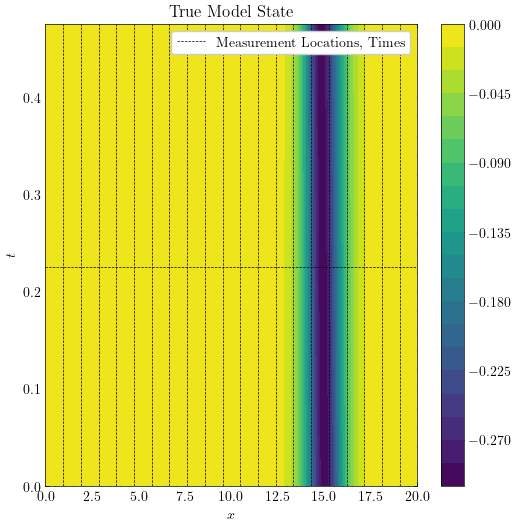

In [10]:
fig, axes = plt.subplots(figsize=(6,6))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue, levels=contour_levels)
num = 0
for coord in spatial_measurement_coordinates.flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations, Times', color='black', linewidth=0.5)
    else:
        axes.axvline(coord, linestyle='--', color='black', linewidth=0.5)
    num += 1
num = 0
for coord in temporal_measurement_coordinates.flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', color='black', linewidth=0.5)
    else:
        axes.axhline(coord, linestyle='--', color='black', linewidth=0.5)
    num += 1

x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

#axes.scatter(x_temp, y_temp, marker='x', label='Observed Points', color='black')
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('True Model State')
fig.colorbar(plot)
plt.legend()
plt.show()

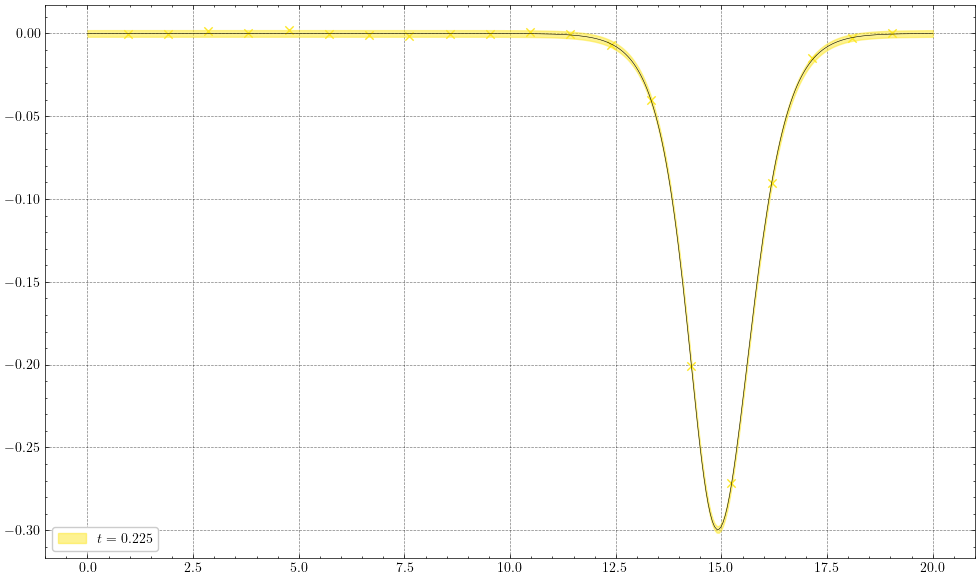

In [11]:
time_labels = [r"$t=$ "+f'{temporal_measurement_coordinates[i]:.3f}' for i in range(len(temporal_measurement_coordinates))]
mes_ind = 0
fig, axes = plt.subplots(figsize=(10,6))
for mes_ind in np.linspace(0, temporal_points - 1, 1, dtype=int): # up to 12
    axes.plot(true_coordinates, u_strue[temporal_measurement_indices[mes_ind],:], color='black', linewidth=0.4)#color=color_list[mes_ind])
    axes.scatter(spatial_measurement_coordinates, u_observed[mes_ind,:], color=color_list[mes_ind], marker='x')
    axes.fill_between(true_coordinates.flatten(), u_strue[temporal_measurement_indices[mes_ind],:] - 2*sigma_n_true,u_strue[temporal_measurement_indices[mes_ind],:] + 2*sigma_n_true, alpha=0.5, color=color_list[mes_ind], label=time_labels[mes_ind])

axes.legend(ncols=2)
fig.tight_layout()
plt.show()

In [ ]:
time_labels = [r"$t=$ "+f'{time_range[i]:.3f}' for i in range(len(time_range))]

for time_index in tqdm(range(len(time_range))):
    filename = r"kdv_pics/image" + str(time_index) + ".png"

    fig, axes = plt.subplots(figsize=(8,4))

    axes.plot(true_coordinates, u_strue[time_index,:], label=time_labels[time_index], color=color_list[11], linewidth=2.)

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')
    axes.set_ylim(-0.3, 0.3)

    axes.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig(filename)
    plt.close()

100%|██████████| 2000/2000 [14:04<00:00,  2.37it/s]


In [33]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 400

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = 0.
x_axis_right_boundary = 20.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.025
t_end = 0.5 #50.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
v_element = fem.ElementLineP0()
u_element = fem.ElementLineP1()
u_basis = fem.Basis(mesh, u_element)
v_basis = fem.Basis(mesh, v_element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)

def sech(x):
    return 1 / np.cosh(x)

u_0 = -0.3*(sech(true_coordinates.flatten() - 15))**2
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.0001, len(u_0))
u_guess[0] = u_guess[-1] 
u_guess[-2] = u_guess[1]

v_0 = np.gradient(u_0)
v_s = np.zeros((number_of_steps, n_x))
v_s[0,:] = v_0

v_guess = v_0+ np.random.normal(0, 0.0001, len(v_0))
v_guess[0] = v_guess[-1]
v_guess[-2] = v_guess[1]

w_0 = np.gradient(v_0)
w_s = np.zeros((number_of_steps, n_x))
w_s[0,:] = w_0

w_guess = w_0 + np.random.normal(0, 0.0001, len(w_0))
w_guess[0] = w_guess[-1]
w_guess[-2] = w_guess[1]

covs = [np.zeros((n_x, n_x))]

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [34]:
K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta_3 = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)
K_theta_3_np = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

def K_theta_mat(rho, ell):
    K_vec = (rho**2)*tensor.math.exp(K_theta_3/(2*(ell**2)))
    K_vec = tensor.reshape(K_vec, (n_x, n_x))
    return tensor.nlinalg.kron([[1,0,0],[0,0,0],[0,0,0]], K_vec)
    #return K_vec

def K_theta_mat_np(rho, ell):
    K_vec = (rho**2)*np.exp(K_theta_3_np/(2*(ell**2)))
    K_vec = np.reshape(K_vec, (n_x, n_x))
    return np.kron([[1,0,0],[0,0,0],[0,0,0]], K_vec)
    #return K_vec

@fem.BilinearForm
def mass(u,v,w):
    return u*v

mass_mat = mass.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mass_mat[-1,-1] = mass_mat[-1,0] = mass_mat[0,0]

@fem.BilinearForm
def mixed(u,v,w):
    return grad(u)[0]*v

mixed_mat = mixed.assemble(ubasis=u_basis, vbasis=v_basis).toarray()
mixed_mat[-1,-1] = mixed_mat[0,0]
mixed_mat[-1,0] = mixed_mat[0,1]

ones_mat = np.ones(np.shape(mass_mat))
zeros_mat = np.zeros(np.shape(mass_mat))

ones_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], ones_mat)
ones_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], ones_mat)
ones_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], ones_mat)
ones_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], ones_mat)
ones_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], ones_mat)
ones_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], ones_mat)

mass_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mass_mat)
mass_22 = np.kron([[0,0,0],[0,1,0],[0,0,0]], mass_mat)
mass_33 = np.kron([[0,0,0],[0,0,0],[0,0,1]], mass_mat)

big_mass_mat = mass_11 + 0.5*mass_22 + 0.5*mass_33

mixed_11 = np.kron([[1,0,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_12 = np.kron([[0,1,0],[0,0,0],[0,0,0]], mixed_mat)
mixed_23 = np.kron([[0,0,0],[0,0,1],[0,0,0]], mixed_mat)
mixed_31 = np.kron([[0,0,0],[0,0,0],[1,0,0]], mixed_mat)

big_mixed_mat = dt*0.5*mixed_11 + dt*0.5*mixed_12 - 0.5*mixed_23 - 0.5*mixed_31

def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return tensor.concatenate((F1, F2, F3))

def fem_lhs_np(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return np.concatenate((F1, F2, F3))

# def fem_jacobian(alpha, beta, c, nu, u, u_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
#     part11 = tensor.as_tensor([dt * c, dt * beta, 0])
#     part12 = tensor.as_tensor([0,0,-1])
#     part13 = tensor.as_tensor([-1,0,0])
#     part1 = tensor.stack([part11,part12,part13])

#     part21 = tensor.as_tensor([(1 + dt * nu / 2), 0, 0])
#     part22 = tensor.as_tensor([0, 1 / 2, 0])
#     part23 = tensor.as_tensor([0, 0, 1 / 2])
#     part2 = tensor.stack([part21,part22,part23])

#     part3 = tensor.as_tensor([[1,0,0],[0,0,0],[0,0,0]])
    
#     jacobian = (
#         tensor.nlinalg.kron(
#             part1,
#             mixed_mat / 2
#             ) 
#             + tensor.nlinalg.kron(
#                 part2,
#                 mass_mat
#                 )
#                 + tensor.nlinalg.kron(
#                     part3,
#                     dt * alpha * tensor.math.mul(mixed_mat, ((u + u_prev) / 2)) / 2
#                     )
#         )
#     return jacobian

def fem_jacobian(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mass_mat=mass_mat):
    precompute = tensor.math.mul(little_mass_mat, (u+u_prev)/2)
    big_precompute = tensor.nlinalg.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = tensor.math.mul(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = tensor.math.mul((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = tensor.math.mul(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

def fem_jacobian_np(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mass_mat=mass_mat):
    precompute = np.multiply(little_mass_mat, (u+u_prev)/2)
    big_precompute = np.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = np.multiply(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = np.multiply((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = np.multiply(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

In [28]:
def fem_lhs(alpha, beta, c, nu, u, v, w, u_prev, v_prev, w_prev, mass_mat=mass_mat, mixed_mat=mixed_mat):
    c1 = u - u_prev
    c2 = u + u_prev
    c3 = w + w_prev
    c4 = v + v_prev
    F1 = (mass_mat @ (c1)
          + (dt * nu) * mass_mat @ ((c2) / 2)
          + (dt * alpha) * mixed_mat @ ((c2)**2 / 4) / 2
          + (dt * beta) * mixed_mat @ ((c3) / 2)
          + (dt * c) * mixed_mat @ ((c2) / 2)
          )
    F2 = mass_mat @ ((c3) / 2) - mixed_mat @ ((c4) / 2)
    F3 = mass_mat @ ((c4) / 2) - mixed_mat @ ((c2) / 2)
    return tensor.concatenate((F1, F2, F3))

def fem_jacobian(alpha, beta, c, nu, u, u_prev, big_mass_mat=big_mass_mat, big_mixed_mat=big_mixed_mat,little_mass_mat=mass_mat):
    precompute = tensor.math.mul(little_mass_mat, (u+u_prev)/2)
    big_precompute = tensor.nlinalg.kron([[dt/2,0,0],[0,0,0],[0,0,0]], precompute)
    jacobian1 = tensor.math.mul(c*ones_11 + beta*ones_12 + ones_23 + ones_31, big_mixed_mat)
    jacobian2 = tensor.math.mul((1+(dt*nu/2))*ones_11 + ones_22 + ones_33, big_mass_mat)
    jacobian3 = tensor.math.mul(alpha*ones_11, big_precompute)
    return jacobian1 + jacobian2 + jacobian3

def iterate_step(u_guess, v_guess, w_guess, alpha, beta, c, nu, u_prev, v_prev, w_prev, n_x):

    # Compute the current residual and Jacobian
    f_curr = fem_lhs(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
    j_curr = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_prev)

    # Solve the linear system for the shift
    shift = tensor.nlinalg.tensorsolve(j_curr, -f_curr)
    
    # Update guesses
    u_guess = u_guess + shift[0:n_x]
    w_guess = w_guess + shift[n_x:2*n_x]
    v_guess = v_guess + shift[2*n_x:]
    
    return u_guess, v_guess, w_guess

u_prev, v_prev, w_prev = u_0, v_0, w_0

initial_guesses = [tensor.shape_padleft(u_0 + np.random.normal(0, 0.0001, len(u_0))), tensor.shape_padleft(v_0 + np.random.normal(0, 0.0001, len(v_0))), tensor.shape_padleft(w_0 + np.random.normal(0, 0.0001, len(w_0)))]

guesses, updates = pt.scan(fn=iterate_step,
                           sequences=[],
                           outputs_info=initial_guesses,
                           non_sequences=[alpha, beta, c, nu, u_prev, v_prev, w_prev, n_x],
                           n_steps=5)

# Get the final guesses after 5 iterations
u_guess_final, v_guess_final, w_guess_final = guesses


TypeError: Inconsistency in the inner graph of scan 'scan_fn' : an input and an output are associated with the same recurrent state and should have compatible types but have type 'Matrix(float64, shape=(1, 400))' and 'Matrix(float64, shape=(?, 400))' respectively.

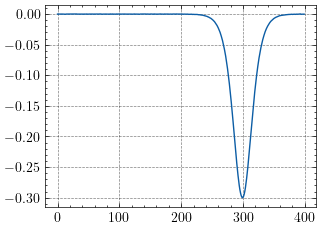

In [31]:
plt.plot(u_0 + np.random.normal(0, 0.0001, len(u_0)))
plt.plot(u_guess_final.eval())

In [32]:
u_guess_final.eval()

TypeError: Inconsistency in the inner graph of scan 'scan_fn' : an input and an output are associated with the same recurrent state and should have compatible types but have type 'Matrix(float64, shape=(1, 400))' and 'Matrix(float64, shape=(?, 400))' respectively.

In [35]:
# PRIORS ------------
#alpha
lower = 0.1
upper = 2.
mu = 1.3
sigma = 1.
alpha_params = [lower, upper, mu, sigma]

# beta
lower = -3.
upper = 1.
mu = -1.
sigma = 1.
beta_params = [lower, upper, mu, sigma]

# c
lower = -3
upper = 3
mu = 0.
sigma = 1.
c_params = [lower, upper, mu, sigma]

# nu
lower = -3
upper = 3
mu = 0
sigma = 1.
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.01
sigma = 0.5
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 1.5
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 0.1
mu = 0.001
sigma = 0.5
sigma_n_params = [lower, upper, mu, sigma]

# --------------

In [36]:
alpha = alpha_params[2]
beta = beta_params[2]
c = c_params[2]
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

traces = [] # box of traces

nugget = 1e-12*np.eye(n_x)

data_index = 0

for i, t in tqdm(enumerate(time_range[:-1])):
    u_prev, v_prev, w_prev = u_s[i,:], v_s[i,:], w_s[i,:]
    #du_norm = 1.
    #while du_norm > newton_tol:
    if time_operator[i] == False: # if we do not have data
        for j in range(5):
            f_curr = fem_lhs_np(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
            j_curr = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_prev)
            shift = np.linalg.solve(j_curr, -f_curr)
            u_guess += shift[0:n_x]
            w_guess += shift[n_x:2*n_x]
            v_guess += shift[2*n_x:]
            #du_norm = np.linalg.norm(shift)
        pred_mean = u_guess
        jacobian = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_guess)
        inv_jacobian = np.linalg.inv(jacobian)
        jacobian_prev = fem_jacobian_np(alpha, beta, c, 10**nu, u_prev, u_prev)
        k_mat = K_theta_mat_np(rho, ell)
        g_mat = mass_11 @ k_mat @ mass_11.T
        prev_cov = np.kron([[1,0,0],[0,0,0],[0,0,0]],covs[-1])
        pred_cov = inv_jacobian @ (jacobian_prev @ prev_cov @ jacobian_prev.T) @ inv_jacobian.T + dt * inv_jacobian @ g_mat @ inv_jacobian.T 
        trunc_pred_cov = pred_cov[:n_x,:n_x] 
        u_s[i+1, :] = pred_mean
        v_s[i+1, :] = v_guess
        w_s[i+1, :] = w_guess
        covs.append(trunc_pred_cov)
    else:
        with pm.Model() as model:
            if data_index == 0:
                alpha = pm.TruncatedNormal('alpha', mu=alpha_params[2], sigma=alpha_params[3], lower=alpha_params[0], upper=alpha_params[1])
                beta = pm.TruncatedNormal('beta', mu=beta_params[2], sigma=beta_params[3], lower=beta_params[0], upper=beta_params[1])
                c = pm.TruncatedNormal('c', mu=c_params[2], sigma=c_params[3], lower=c_params[0], upper=c_params[1])
                nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
                #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
                rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
                ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
                sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
            else:
                alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
                beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
                c = pm.TruncatedNormal('c', mu=c, sigma=c_std, lower=c_params[0], upper=c_params[1])
                nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_params[0], upper=nu_params[1])
                #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
                rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
                ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
                sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])

            for j in range(5):
                f_curr = fem_lhs(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
                j_curr = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_prev)
                shift = tensor.nlinalg.tensorsolve(j_curr, -f_curr).eval()
                u_guess += shift[0:n_x]
                w_guess += shift[n_x:2*n_x]
                v_guess += shift[2*n_x:]
            mu_u = pm.Deterministic('mu_u', tensor.as_tensor(observation_operator @ u_guess))

            jacobian = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_guess)
            inv_jacobian = tensor.linalg.inv(jacobian)
            prev_jacobian = fem_jacobian(alpha, beta, c, 10**nu, u_prev, u_prev)
            k_mat = K_theta_mat(rho, ell)
            g_mat = mass_11 @ k_mat @ mass_11.T
            prev_cov = tensor.as_tensor(np.kron([[1,0,0],[0,0,0],[0,0,0]],covs[-1]))
            cov_1 = inv_jacobian @ prev_jacobian @ prev_cov @ prev_jacobian.T @ inv_jacobian.T
            cov_2 = dt*inv_jacobian @ g_mat @ inv_jacobian.T
            cov_1_trunc = cov_1[:n_x, :n_x]
            cov_2_trunc = cov_2[:n_x, :n_x]
            cov_u = pm.Deterministic('cov_u', observation_operator @ cov_1_trunc @ observation_operator.T + observation_operator @ cov_2_trunc @ observation_operator.T + (sigma_n**2)*tensor.eye(spatial_points))
            cov_chol = pm.Deterministic('cov_chol', tensor.linalg.cholesky(cov_u))
            y_obs = pm.MvNormal('y_obs', mu=mu_u, chol=cov_chol, observed = u_observed[data_index,:])
            trace = pm.sample(nuts_sampler="numpyro",chains=2, target_accept=0.95, var_names=['alpha','beta','c','nu','rho','ell','sigma_n'])
            traces.append(trace)


        # update parameters to means of their posteriors
        alpha = np.mean(traces[-1].posterior['alpha'].data.flatten())
        alpha_std = np.std(traces[-1].posterior['alpha'].data.flatten())
        #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        alpha_updated_params = [alpha_params[0], alpha_params[1], alpha, alpha_std]

        beta = np.mean(traces[-1].posterior['beta'].data.flatten())
        beta_std = np.std(traces[-1].posterior['beta'].data.flatten())
        #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        beta_updated_params = [beta_params[0], beta_params[1], beta, beta_std]

        c = np.mean(traces[-1].posterior['c'].data.flatten())
        c_std = np.std(traces[-1].posterior['c'].data.flatten())
        #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        c_updated_params = [c_params[0], c_params[1], c, c_std]

        nu = np.mean(traces[-1].posterior['nu'].data.flatten())
        nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
        #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        nu_updated_params = [nu_params[0], nu_params[1], nu, nu_std]

        rho = np.mean(traces[-1].posterior['rho'].data.flatten())
        rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
        #rho_updated_params = [rho - 3*rho_std, rho + 3*rho_std, rho, rho_std]
        rho_updated_params = [rho_params[0], rho_params[1], rho, rho_std]

        ell = np.mean(traces[-1].posterior['ell'].data.flatten())
        ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
        #ell_updated_params = [ell - 3*ell_std, ell + 3*ell_std, ell, ell_std]
        ell_updated_params = [ell_params[0], ell_params[1], ell, ell_std]

        sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
        sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
        #sigma_n_updated_params = [sigma_n- 3*sigma_n_std, sigma_n + 3*sigma_n_std, sigma_n, sigma_n_std]
        sigma_n_updated_params = [sigma_n_params[0], sigma_n_params[1], sigma_n, sigma_n_std]


        for j in range(5):
            f_curr = fem_lhs_np(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
            j_curr = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_prev)
            shift = np.linalg.solve(j_curr, -f_curr)
            u_guess += shift[0:n_x]
            w_guess += shift[n_x:2*n_x]
            v_guess += shift[2*n_x:]
            #du_norm = np.linalg.norm(shift)
        pred_mean = u_guess
        jacobian = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_guess)
        inv_jacobian = np.linalg.inv(jacobian)
        jacobian_prev = fem_jacobian_np(alpha, beta, c, 10**nu, u_prev, u_prev)
        k_mat = K_theta_mat_np(rho, ell)
        g_mat = mass_11 @ k_mat @ mass_11.T
        prev_cov = np.kron([[1,0,0],[0,0,0],[0,0,0]],covs[-1])
        pred_cov = inv_jacobian @ (jacobian_prev @ prev_cov @ jacobian_prev.T) @ inv_jacobian.T + dt * inv_jacobian @ g_mat @ inv_jacobian.T 
        trunc_pred_cov = pred_cov[:n_x,:n_x] 
        S_n = observation_operator @ trunc_pred_cov @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points)
        S_n_inverse = np.linalg.inv(S_n)
        updated_mean = pred_mean + trunc_pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
        updated_cov = trunc_pred_cov - trunc_pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ trunc_pred_cov
        u_s[i+1, :] = updated_mean
        v_s[i+1, :] = v_guess
        w_s[i+1, :] = w_guess
        covs.append(updated_cov)
        data_index += 1

        

    #else: # if we do have data
        # with pm.Model() as model:
        #     if data_index == 0:
        #         alpha = pm.TruncatedNormal('alpha', mu=alpha_params[2], sigma=alpha_params[3], lower=alpha_params[0], upper=alpha_params[1])
        #         beta = pm.TruncatedNormal('beta', mu=beta_params[2], sigma=beta_params[3], lower=beta_params[0], upper=beta_params[1])
        #         c = pm.TruncatedNormal('c', mu=c_params[2], sigma=c_params[3], lower=c_params[0], upper=c_params[1])
        #         nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
        #         #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
        #         rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
        #         ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
        #         sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
        #     else:
        #         alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
        #         beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
        #         c = pm.TruncatedNormal('c', mu=c, sigma=c_std, lower=c_params[0], upper=c_params[1])
        #         nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_params[0], upper=nu_params[1])
        #         #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
        #         rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
        #         ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
        #         sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])

        #     #du_norm = 1.

        #     #while du_norm > newton_tol:
        #     for j in range(3):
        #         f_curr = fem_lhs(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        #         j_curr = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_prev)
        #         shift = tensor.nlinalg.tensorsolve(j_curr, -f_curr)
        #         shift_eval = shift.eval()
        #         u_guess += shift_eval[0:n_x]
        #         w_guess += shift_eval[n_x:2*n_x]
        #         v_guess += shift_eval[2*n_x:]

        #         #du_norm = np.linalg.norm(shift_eval)

        #     mu_u = pm.Deterministic('mu_u', tensor.as_tensor(observation_operator @ u_guess))

        #     #j_mat = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_prev)
        #     #j_local = j_mat[:n_x, :n_x]
        #     j_local = j_curr[:n_x, :n_x]
        #     inv_j_mat = tensor.nlinalg.inv(j_local)
        #     # j_mat_prev = fem_jacobian(alpha, beta, c, 10**nu, u_prev, u_s[i-1,:])
        #     # j_local_prev = j_mat_prev[:n_x, :n_x]

        #     cov_1 = pm.Deterministic('cov_1', inv_j_mat @ j_prev_locals[-1] @ covs[-1] @ j_prev_locals[-1].T @ inv_j_mat.T)
        #     cov_2 = pm.Deterministic('cov_2', inv_j_mat @ mass_mat @ K_theta_mat(rho, ell) @ mass_mat.T @ inv_j_mat.T)
        #     cov_u = pm.Deterministic('cov_u', observation_operator @ cov_1 @ observation_operator.T + dt * observation_operator @ cov_2 @ observation_operator.T + (sigma_n**2)*np.eye(spatial_points))
        #     cov_chol = pm.Deterministic('cov_chol', tensor.linalg.cholesky(cov_u))

        #     y_obs = pm.MvNormal('y_obs', mu = mu_u, chol = cov_chol, observed = u_observed[data_index,:])
        #     #nuts_sampler="numpyro",
        #     trace = pm.sample(draws=500, chains=2, target_accept=0.95, var_names=['alpha','beta','c','nu','rho','ell','sigma_n'])
        #     #trace = pm.sample()
        #     traces.append(trace)

        # # update parameters to means of their posteriors
        # alpha = np.mean(traces[-1].posterior['alpha'].data.flatten())
        # alpha_std = np.std(traces[-1].posterior['alpha'].data.flatten())
        # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        # alpha_updated_params = [alpha_params[0], alpha_params[1], alpha, alpha_std]

        # beta = np.mean(traces[-1].posterior['beta'].data.flatten())
        # beta_std = np.std(traces[-1].posterior['beta'].data.flatten())
        # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        # beta_updated_params = [beta_params[0], beta_params[1], beta, beta_std]

        # c = np.mean(traces[-1].posterior['c'].data.flatten())
        # c_std = np.std(traces[-1].posterior['c'].data.flatten())
        # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        # c_updated_params = [c_params[0], c_params[1], c, c_std]

        # nu = np.mean(traces[-1].posterior['nu'].data.flatten())
        # nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
        # #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
        # nu_updated_params = [nu_params[0], nu_params[1], nu, nu_std]

        # rho = np.mean(traces[-1].posterior['rho'].data.flatten())
        # rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
        # #rho_updated_params = [rho - 3*rho_std, rho + 3*rho_std, rho, rho_std]
        # rho_updated_params = [rho_params[0], rho_params[1], rho, rho_std]

        # ell = np.mean(traces[-1].posterior['ell'].data.flatten())
        # ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
        # #ell_updated_params = [ell - 3*ell_std, ell + 3*ell_std, ell, ell_std]
        # ell_updated_params = [ell_params[0], ell_params[1], ell, ell_std]

        # sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
        # sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
        # #sigma_n_updated_params = [sigma_n- 3*sigma_n_std, sigma_n + 3*sigma_n_std, sigma_n, sigma_n_std]
        # sigma_n_updated_params = [sigma_n_params[0], sigma_n_params[1], sigma_n, sigma_n_std]

        #du_norm = 1.
        #while du_norm > newton_tol:
        # for j in range(3):
        #     f_curr = fem_lhs_np(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        #     j_curr = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_prev)

        #     shift = np.linalg.solve(j_curr, -f_curr)

        #     u_guess += shift[0:n_x]
        #     w_guess += shift[n_x:2*n_x]
        #     v_guess += shift[2*n_x:]

        #     du_norm = np.linalg.norm(shift)

        # pred_mean = u_guess
        # j_curr = fem_jacobian_np(alpha, beta, c, 10**nu, u_guess, u_prev)
        # j_local = j_curr[:n_x, :n_x]
        # inv_jacobs = np.linalg.inv(j_local)

        # if i==0:
        #     pred_cov = dt * inv_jacobs @ mass_mat @ K_theta_mat_np(rho, ell) @ mass_mat.T @ inv_jacobs.T
        # else:
        #     j_mat_prev = fem_jacobian_np(alpha, beta, c, 10**nu, u_prev, u_s[i-1,:])
        #     j_local_prev = j_mat_prev[:n_x, :n_x]
        #     C1 = inv_jacobs @ (j_local_prev @ covs[-1] @ j_local_prev.T) @ inv_jacobs.T
        #     C2 = dt * inv_jacobs @ mass_mat @ K_theta_mat_np(rho, ell) @ mass_mat.T @ inv_jacobs.T
        #     pred_cov = C1 + C2

        # S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
        # updated_mean = pred_mean + pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ (u_observed[data_index,:] - observation_operator @ pred_mean)
        # updated_cov = pred_cov - pred_cov @ observation_operator.T @ np.linalg.inv(S_n) @ observation_operator @ pred_cov
        # covs.append(updated_cov)
        # u_s[i+1, :] = updated_mean
        # v_s[i+1, :] = v_guess
        # w_s[i+1, :] = w_guess
        # data_index += 1

9it [00:07,  1.40it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
19it [8:25:20, 1595.83s/it]


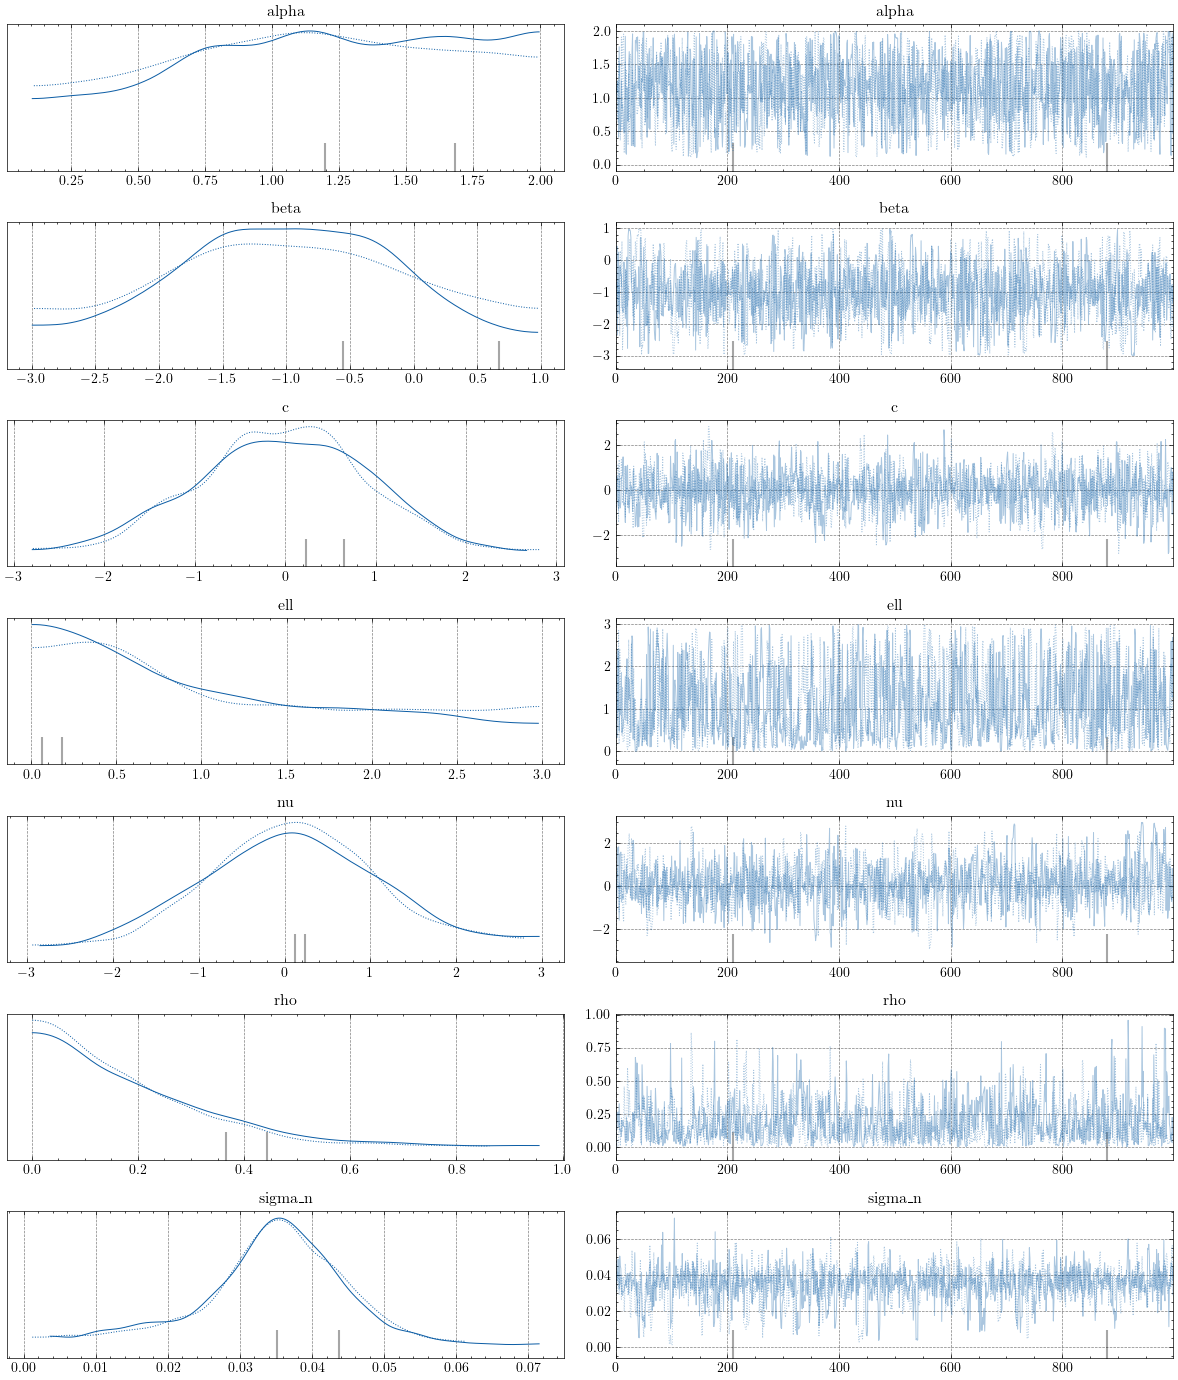

In [40]:
az.plot_trace(traces[0])
plt.tight_layout()

In [103]:
(observation_operator @ cov_1 @ observation_operator.T + observation_operator @ cov_2 @ observation_operator.T + (sigma_n**2)*tensor.eye(spatial_points)).eval()

ValueError: Shape mismatch: x has 400 cols (and 20 rows) but y has 1200 rows (and 1200 cols)
Apply node that caused the error: Dot22([[0. 0. 0. ... 0. 0. 0.]], Transpose{axes=[1, 0]}.0)
Toposort index: 36
Inputs types: [TensorType(float64, shape=(20, 400)), TensorType(float64, shape=(1200, 1200))]
Inputs shapes: [(20, 400), (1200, 1200)]
Inputs strides: [(3200, 8), (9600, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Dot22(Dot22.0, [[0. 0. 0. ... 0. 0. 0.]])]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2647679/1988184565.py", line 1, in <module>
    (observation_operator @ cov_1 @ observation_operator.T + observation_operator @ cov_2 @ observation_operator.T + (sigma_n**2)*tensor.eye(spatial_points)).eval()

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
observation_operator @ cov_1 @ observation_operator.T)

In [102]:
np.shape(cov_2_trunc.eval())

(400, 400)

In [74]:
time_operator[9]

True

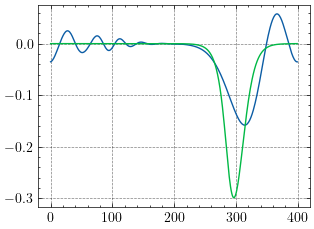

In [70]:
plt.plot(u_s[15,:])
plt.plot(u_strue[15,:])

In [114]:
with pm.Model() as model:
    if data_index == 0:
        alpha = pm.TruncatedNormal('alpha', mu=alpha_params[2], sigma=alpha_params[3], lower=alpha_params[0], upper=alpha_params[1])
        beta = pm.TruncatedNormal('beta', mu=beta_params[2], sigma=beta_params[3], lower=beta_params[0], upper=beta_params[1])
        c = pm.TruncatedNormal('c', mu=c_params[2], sigma=c_params[3], lower=c_params[0], upper=c_params[1])
        nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
        #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
        rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
        ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
        sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
    else:
        alpha = pm.TruncatedNormal('alpha', mu=alpha, sigma=alpha_std, lower=alpha_params[0], upper=alpha_params[1])
        beta = pm.TruncatedNormal('beta', mu=beta, sigma=beta_std, lower=beta_params[0], upper=beta_params[1])
        c = pm.TruncatedNormal('c', mu=c, sigma=c_std, lower=c_params[0], upper=c_params[1])
        nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_params[0], upper=nu_params[1])
        #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
        rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_params[0], upper=rho_params[1])
        ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_params[0], upper=ell_params[1])
        sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_params[0], upper=sigma_n_params[1])

    for j in range(3):
        f_curr = fem_lhs(alpha, beta, c, 10**nu, u_guess, v_guess, w_guess, u_prev, v_prev, w_prev)
        j_curr = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_prev)
        shift = tensor.nlinalg.tensorsolve(j_curr, -f_curr).eval()
        u_guess += shift[0:n_x]
        w_guess += shift[n_x:2*n_x]
        v_guess += shift[2*n_x:]
    mu_u = pm.Deterministic('mu_u', tensor.as_tensor(observation_operator @ u_guess))

    jacobian = fem_jacobian(alpha, beta, c, 10**nu, u_guess, u_guess)
    inv_jacobian = tensor.linalg.inv(jacobian)
    prev_jacobian = fem_jacobian(alpha, beta, c, 10**nu, u_prev, u_prev)
    k_mat = K_theta_mat(rho, ell)
    g_mat = mass_11 @ k_mat @ mass_11.T
    prev_cov = tensor.as_tensor(np.kron([[1,0,0],[0,0,0],[0,0,0]],covs[-1]))
    cov_1 = inv_jacobian @ prev_jacobian @ prev_cov @ prev_jacobian.T @ inv_jacobian.T
    cov_2 = dt*inv_jacobian @ g_mat @ inv_jacobian.T
    cov_1_trunc = cov_1[:n_x, :n_x]
    cov_2_trunc = cov_2[:n_x, :n_x]
    cov_u = pm.Deterministic('cov_u', observation_operator @ cov_1_trunc @ observation_operator.T + observation_operator @ cov_2_trunc @ observation_operator.T + (sigma_n**2)*tensor.eye(spatial_points))
    cov_chol = pm.Deterministic('cov_chol', tensor.linalg.cholesky(cov_u))
    y_obs = pm.MvNormal('y_obs', mu=mu_u, chol=cov_chol, observed = u_observed[data_index,:])

In [115]:
logp_func = model.compile_dlogp(profile=True)
logp_func.f.profile.summary()

Function profiling
  Message: /home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/pymc/pytensorf.py:1039
  Time in 0 calls to Function.__call__: 0.000000e+00s
  Total compilation time: 4.176492e+00s
    Number of Apply nodes: 176
    PyTensor rewrite time: 3.315947e+00s
       PyTensor validate time: 4.389199e-02s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.8421376710757613s
       C-cache preloading 5.966759e-03s
       Import time 0.000000e+00s
       Node make_thunk time 8.329101e-01s
           Node Composite{...}(ExpandDims{axes=[0, 1]}.0, [[1. 1. 1. ... 0. 0. 0.]], [[ 1.02957 ... 0000e+00]], [[0.025062 ... 01253133]], [[0. 0. 0. ... 0. 0. 0.]], [[0. 0. 0. ... 1. 1. 1.]], Pow.0, [[-0.0125 ... 0.    ]], [[0. 0. 0. ... 0. 0. 0.]], [[0. 0. 0. ... 0. 0. 0.]], ExpandDims{axes=[0, 1]}.0, [[0. 0. 0. ... 0. 0. 0.]], ExpandDims{axes=[0, 1]}.0, [[3.424475 ... 0000e+00]]) time 2.773458e-01s
           Node Composite{...}(Transpose{axes=[1, 0]}.0, Dot

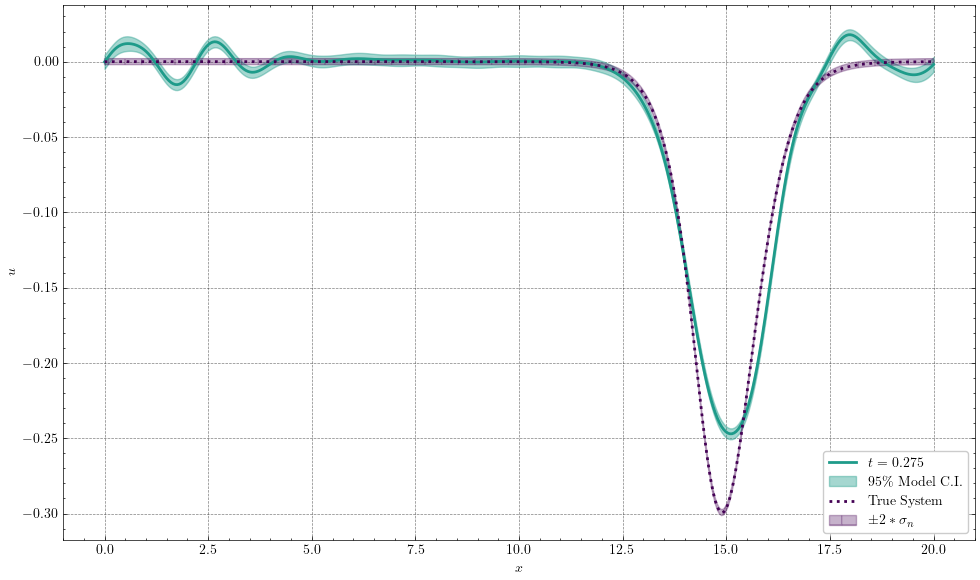

In [86]:
cov_diags = np.zeros((number_of_steps, number_of_x_axial_cells))
for i in range(19):#number_of_steps):
    cov_diags[i,:] = np.diag(covs[i])

sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

time_index = 11
time_labels = [r"$t=$ "+str(time_range[i]) for i in range(len(time_range))]

fig, axes = plt.subplots(figsize=(10,6))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5], linewidth=2.)
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), alpha=0.4, color=color_list[5], label=r'$95\%$ Model C.I.')
#axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(cov_diags[time_index]), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
#axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]), u_s[time_index,:] + 2*np.sqrt(cov_diags[time_index]) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()

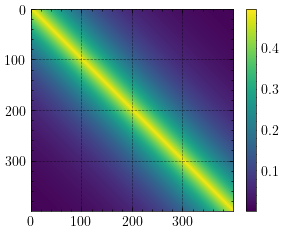

In [ ]:
plt.imshow(covs[80])
plt.colorbar()